In [1]:
# -*- coding: utf-8 -*-

## Map Generalization for Polygons using Autoencode-like strucutures
## Adatped based on Master Thesis of SERCAN CAKIR "ROAD NETWORK EXTRACTION USING CNN"
## Author: Yu Feng, yuzz.feng@gmail.com
## 1. Version Author: SERCAN CAKIR

## Changes:
## 1. Two conv layers were added before the first down convlusional layer
## 2. Output can be any size during the evaluation
## 3. Adapt the code to support more images as training examples
## 4. Dropouot may make the sharpe corners vanishing, we delete half of them, but we should used some
## 5. 

import matplotlib
#matplotlib.use('Agg') # necessary for linux kernal
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
from numpy import random
np.random.seed(7)
import keras
from keras.models import Sequential
from keras.callbacks import History
from keras.layers.core import Dropout
#from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation
from keras import backend as K

from keras.models import Model
from keras.layers import Input, Conv2D, Dropout, UpSampling2D, Activation, Concatenate

from osgeo import gdal
from sklearn.model_selection import train_test_split
from skimage.util.shape import view_as_windows

# function to read .tif image files
def readImg(img):
    # Read heatmap
    image = gdal.Open(img)
    # Get band of heatmap, it's gray scale image!
    img_band = image.GetRasterBand(1)
    # Read the image as array
    image = img_band.ReadAsArray()
    # Normalize the pixel values in the range 0-1 acc. to max. normalization
    image = (image - image.min()) / (image.max() - image.min())
    return image.astype('float32')


# function to read .tif image files
def readImgInv(img):
    # Read heatmap
    image = gdal.Open(img)
    # Get band of heatmap, it's gray scale image!
    img_band = image.GetRasterBand(1)
    # Read the image as array
    image = img_band.ReadAsArray()
    # Normalize the pixel values in the range 0-1 acc. to max. normalization
    image = (image - image.min()) / (image.max() - image.min())
    
    return image.astype('float32')


# function to create image patches
def imagePatches(img1, p_w, p_h, stride):
    img_1 = view_as_windows(img1, (p_w, p_h), stride)
    a, b, h, w = img_1.shape
    img_1_1 = np.reshape(img_1, (a * b, p_w, p_h))
    return img_1_1

# functions to remove fully black images from heatmap and target data, and all the correspondences
def removeBlackImg(img_patch):
    patch_list = []
    patch_list_new = []
    for i in range(len(img_patch)):
        patch_list.append(img_patch[i])
        if patch_list[i].max() != 0:
            patch_list_new.append(img_patch[i])
    return patch_list_new

# remove roads if heats are black
def removeCorrespondence(road, heat):  
    patch_road_list = []
    patch_heat_list = []
    patch_road_list_new = []
    for i in range(len(road)):
        patch_road_list.append(road[i])
        patch_heat_list.append(heat[i])
        if patch_heat_list[i].max() != 0:
            patch_road_list_new.append(road[i])
    return patch_road_list_new



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# function to load a saved model
def LoadModel(model_json):
    from keras.models import model_from_json
    json_file = open(model_json)
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model


##### function to calculate evaluation parameters (F1-Score, Precision, Recall) ######
def evaluation(model, x_test, y_test, patch_size):
    precision = []
    recall = []
    f1Score = []
    import math
    for k in range(len(x_test_sim)):
        y_pred = model.predict(x_test_sim[k:k + 1])
        y_pred = np.reshape(y_pred, (32 * 32))

        y_true = y_test_sim[k:k + 1]
        y_true = np.reshape(y_true, (32 * 32))

        TP = 0
        FP = 0
        FN = 0
        TN = 0

        y_pred = np.round(y_pred)
        for i in range(len(y_pred)):
            if y_true[i] == y_pred[i] == 1:
                TP += 1
            elif y_pred[i] == y_true[i] == 0:
                TN += 1
            elif y_pred[i] == 1 and y_true[i] != y_pred[i]:
                FP += 1
            elif y_pred[i] == 0 and y_true[i] != y_pred[i]:
                FN += 1

        precision.append(TP / (TP + FP + K.epsilon()))  # completeness
        recall.append(TP / (TP + FN))  # correctness
        beta = 1
        f1Score.append((math.pow(beta, 2) + 1) * TP / ((math.pow(beta, 2) + 1) * TP + math.pow(beta, 2) * FN + FP))
        # eval_list = [precision,  recall, f1Score]

    avg_precision = sum(precision) / len(precision)
    avg_recall = sum(recall) / len(precision)
    avg_f1score = sum(f1Score) / len(precision)
    avg_eval_param = [avg_precision, avg_recall, avg_f1score]
    return avg_eval_param

In [3]:
## Building the CNN archıtecture with "Sequential Model" (model looks like autoencoder)
## Version with batch normalozation - Do not benifit that much

def create_model_batch(optimizer, input_shape):
    
    model = Sequential()
    droprate = 0.3
    
    model.add(Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same',
              input_shape=input_shape, kernel_initializer='random_uniform', name="flat_conv_a"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same', name="flat_conv_b"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    ## Encoding (down-sampling) ###   
    model.add(Conv2D(filters=24, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     name="down_conv_1"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_1"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_2"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    ## Encoding (down-sampling) ### 
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     name="down_conv_2"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_3"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_4"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_5"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_6"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=512, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_6a"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=512, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_6b"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=512, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_6c"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_7"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_8"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    
    ###############################################################################
    model.add(UpSampling2D(size=(2, 2), name='up_samp_1'))
    
    model.add(Conv2D(filters=64, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     name="up_conv_1"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_9"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_10"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))
    ###############################################################################
    model.add(UpSampling2D(size=(2, 2), name='up_samp_2'))

    model.add(Conv2D(filters=24, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     name="up_conv_2"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=12, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     name="flat_conv_11"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=1, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='sigmoid', name="flat_conv_12"))
    # model.add(Activation(our_activation))
    model.add(Dropout(droprate))

    # Compile model with Adam optimizer and binary cross entropy loss function
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

In [4]:
##### Building the CNN archıtecture with "Sequential Model" 
##### (model looks like autoencoder)
def create_model(optimizer, input_shape):
    model = Sequential()
    
    droprate = 0.3

    model.add(Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same',
              activation='relu', input_shape=input_shape, kernel_initializer='random_uniform',
              name="flat_conv_a"))
    #model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same',
              activation='relu',name="flat_conv_b"))
    #model.add(Dropout(droprate))
    
#    model.add(Conv2D(filters=24, kernel_size=(3, 3),
#              strides=(1, 1), padding='same',
#              activation='relu',name="flat_conv_c"))
#    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
#    model.add(Dropout(droprate))
    
    ## Encoding (down-sampling) ###   
    model.add(Conv2D(filters=24, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     activation='relu', #input_shape=input_shape, kernel_initializer='random_uniform',
                     name="down_conv_1"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_1"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_2"))
    #model.add(Dropout(droprate))
    ##############################################################################
    
#    model.add(Conv2D(filters=24, kernel_size=(3, 3),
#              strides=(1, 1), padding='same',
#              activation='relu',name="down_conv_2"))
#    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
#    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     activation='relu', name="down_conv_2"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_3"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_4"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_5"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_6"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_7"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_8"))
    model.add(Dropout(droprate))
    ###############################################################################
    model.add(UpSampling2D(size=(2, 2), name='up_samp_1'))
    
#    model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), 
#                              padding='same', activation='softmax'))
    

    model.add(Conv2D(filters=64, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_1"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_9"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_10"))
    #model.add(Dropout(droprate))
    ###############################################################################
    model.add(UpSampling2D(size=(2, 2), name='up_samp_2'))
    
#    model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), # Lead the accuracy to 0.78
#                              padding='same', activation='softmax'))

    model.add(Conv2D(filters=24, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_2"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=12, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_11"))
    #model.add(Dropout(droprate))

    model.add(Conv2D(filters=1, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='sigmoid', name="flat_conv_12"))
    # model.add(Activation(our_activation))
    #model.add(Dropout(droprate))

    # Compile model with Adam optimizer and binary cross entropy loss function
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model


# model_ex1.summary()

##################################################################################################################################
#class Covariance(keras.callbacks.Callback):
#
#    def on_train_begin(self, logs={}):
#        self.avg_cov1 = []
#        self.avg_cov2 = []
#
#    def on_epoch_end(self, epoch, logs={}):
#        x_val1, y_true1 = x_train_sim, y_train_sim
#        y_pred1 = self.model.predict(x_val1)
#
#        x_val2, y_true2 = x_test_sim, y_test_sim
#        y_pred2 = self.model.predict(x_val2)
#
#        cov_1 = []
#        max_cov1 = []
#        for i in range(len(y_pred1)):
#            y_pred_clip1 = np.reshape(y_pred1[i][1:(len(y_pred1[1]) - 1), 1:(len(y_pred1[1]) - 1)],
#                                      ((len(y_pred1[1]) - 2) ** 2, 1))  # (len(y_pred1)-1)=31
#            y_true_1 = imagePatches(np.reshape(y_true1[i], (len(y_pred1[1]), len(y_pred1[1]))), (len(y_pred1[1]) - 2),
#                                    (len(y_pred1[1]) - 2), 1)
#            for k in range(0, 9):
#                cov_1.append(sum((y_pred_clip1 - y_pred_clip1.mean()) * (
#                            np.reshape(y_true_1[k], ((len(y_pred1[1]) - 2) ** 2, 1)) - (
#                        np.reshape(y_true_1[k], ((len(y_pred1[1]) - 2) ** 2, 1)).mean()))) / len(
#                    y_pred_clip1))  # 900
#        for j in range(0, 9 * len(y_pred1), 9):
#            max_cov1.append(max(cov_1[j:j + 9]))
#
#        cov_2 = []
#        max_cov2 = []
#        for i in range(len(y_pred2)):
#            y_pred_clip2 = np.reshape(y_pred2[i][1:(len(y_pred2[1]) - 1), 1:(len(y_pred2[1]) - 1)],
#                                      ((len(y_pred2[1]) - 2) ** 2, 1))  # (len(y_pred1)-1)=31
#            y_true_2 = imagePatches(np.reshape(y_true2[i], (len(y_pred2[1]), len(y_pred2[1]))), (len(y_pred2[1]) - 2),
#                                    (len(y_pred2[1]) - 2), 1)
#            for k in range(0, 9):
#                cov_2.append(sum((y_pred_clip2 - y_pred_clip2.mean()) * (
#                            np.reshape(y_true_2[k], ((len(y_pred2[1]) - 2) ** 2, 1)) - (
#                        np.reshape(y_true_2[k], ((len(y_pred2[1]) - 2) ** 2, 1)).mean()))) / len(
#                    y_pred_clip2))  # 900
#        for j in range(0, 9 * len(y_pred2), 9):
#            max_cov2.append(max(cov_2[j:j + 9]))
#        print('\n avg_cov: {} - val_avg_cov: {}\n'.format(np.mean(max_cov1), np.mean(max_cov2)))
#
#        self.avg_cov1.append(np.mean(max_cov1))
#        self.avg_cov2.append(np.mean(max_cov2))


##################################################################################################################################
class LearningRateTracker(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.lr_list = []

    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        # lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        lr = K.eval(
            optimizer.lr * (1. / (1. + optimizer.decay * K.cast(optimizer.iterations, K.dtype(optimizer.decay)))))
        print('\n LR: {}\n'.format(lr))
        self.lr_list.append(lr)

##################################################################################################################################
class SaveWeights(keras.callbacks.Callback):  # Saves weights after each 25 epochs
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 49 == 0:
            model_json = self.model.to_json()
            with open("model_" + str(epoch) + ".json", "w") as json_file:
                json_file.write(model_json)
            self.model.save_weights("weights_model_" + str(epoch) + ".h5")
            print("Saved model-weights to disk")

##################################################################################################################################

In [5]:
##### Building the CNN archıtecture with "Model" - skip connections were added
def create_model_add_skips(optimizer, input_shape, drop_rate = 0.3):

    
    i = Input(shape=input_shape)
    
    
    
    x = Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same',
              activation='relu', input_shape=input_shape, kernel_initializer='random_uniform',
              name="flat_conv_a")(i)
    first_skip = Conv2D(filters=24, kernel_size=(3, 3),
              strides=(1, 1), padding='same',
              activation='relu',name="flat_conv_b")(x)
    x = Conv2D(filters=24, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     activation='relu',
                     name="down_conv_1")(first_skip)
    x = Dropout(drop_rate)(x) ################################################# First Drop
    
    
    
    x = Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_1")(x)
    second_skip = Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_2")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     activation='relu', name="down_conv_2")(second_skip)
    x = Dropout(drop_rate)(x) ################################################# Second Drop
    
    
    
    x = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_3")(x)
    third_skip = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_4")(x)
    x = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     activation='relu', name="down_conv_3")(third_skip)
    x = Dropout(drop_rate)(x) ################################################# Third Drop
    
    
    
    x = Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_5")(x)
    x = Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_6")(x)
    x = Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_7")(x)
    x = Dropout(drop_rate)(x) ################################################# 4th Drop
    
    
    x = UpSampling2D(size=(2, 2), name='up_samp_0')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_0")(x)
    concat0 = Concatenate()([third_skip, x])
    x = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_8")(concat0)
    x = Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_8b")(x)
    x = Dropout(drop_rate)(x) ################################################# 5th Drop
    
    
    x = UpSampling2D(size=(2, 2), name='up_samp_1')(x)
    x = Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_1")(x)
    concat = Concatenate()([second_skip, x])
    x = Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_9")(concat)
    x = Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_10")(x)
    x = Dropout(drop_rate)(x) ################################################# 6th Drop
    
    
    x = UpSampling2D(size=(2, 2), name='up_samp_2')(x)
    x = Conv2D(filters=24, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_2")(x)
    concat2 = Concatenate()([first_skip, x])
    x = Conv2D(filters=12, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_11")(concat2)
    x = Conv2D(filters=12, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_11b")(x)
    x = Dropout(drop_rate)(x) ################################################# 7th Drop
    
    
    o = Conv2D(filters=1, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='sigmoid', name="flat_conv_12")(x)
    model = Model(inputs=i, outputs=o)

    # Compile model with Adam optimizer and binary cross entropy loss function
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

Number of tiles:  16828
15828 1000 15828 1000
Input Shape of the models (15828, 128, 128, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flat_conv_a (Conv2D)         (None, None, None, 24)    240       
_________________________________________________________________
flat_conv_b (Conv2D)         (None, None, None, 24)    5208      
_________________________________________________________________
down_conv_1 (Conv2D)         (None, None, None, 24)    5208      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 24)    0         
_________________________________________________________________
flat_conv_1 (Conv2D)         (None, None, None, 64)    13888     
_________________________________________________________________
flat_conv_2 (Conv2D)         (None, None, None, 64)    36928     
_________________________________________________

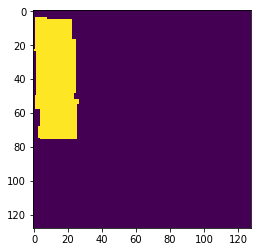

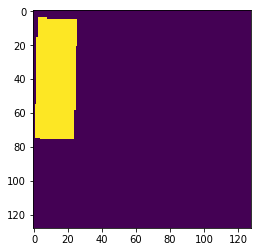

In [6]:
# Order the image dimension acc. to TensorFlow (batc_hsize, rows, cols, channels)
K.set_image_dim_ordering('tf')

# set the working directory
#os.chdir(r'F:\sercan\input_images')
PATH = os.getcwd()
#plt.gray()
#plt.show()


p_size_1 = 128 # Compared with 256, which larger may generate round corners

def data_collector(fns_input, fns_output):
    
    sim_input = []
    sim_output = []
    
    for fn_input, fn_output in zip(fns_input, fns_output):
        
        # load simulated heat map (TRAJECTORY SIMULATION) and target road for Hannover ####
        sim_heatmap_hannover = readImg(fn_input)
        sim_road_hannover = readImg(fn_output)
        
        sim_hm_patches_overlap = imagePatches(sim_heatmap_hannover, p_size_1, p_size_1, int(p_size_1))
        sim_road_patches_overlap = imagePatches(sim_road_hannover, p_size_1, p_size_1, int(p_size_1))
        sim_road_patches_overlap_new = removeCorrespondence(sim_road_patches_overlap, sim_hm_patches_overlap)
        sim_hm_patches_overlap_new = removeCorrespondence(sim_hm_patches_overlap, sim_road_patches_overlap)
        sim_road_patches_overlap_new_new = removeBlackImg(sim_road_patches_overlap)
        
        sim_input += sim_hm_patches_overlap_new
        sim_output += sim_road_patches_overlap_new_new
    
    return sim_input, sim_output

fns_input = [r"data/traininput_inv.png"]
fns_output = [r"data/trainoutput_inv.png"]

#fns_input = [r"data/input2.tif"]#, r"data/geb1_inp_inv_cut.tif"]
#fns_output = [r"data/output2.tif"]#, r"data/geb1_out_inv_cut.tif"]
sim_hm_patches_32_new, sim_road_patches_32_new_new = data_collector(fns_input, fns_output)


### load simulated heat map (TRAJECTORY SIMULATION) and target road for Hannover ####
##sim_heatmap_hannover = readImg(r"data/input2.tif")
##sim_road_hannover = readImg(r"data/output2.tif")

##sim_hm_patches_overlap = imagePatches(sim_heatmap_hannover, p_size_1, p_size_1, int(p_size_1 / 2))
##sim_road_patches_overlap = imagePatches(sim_road_hannover, p_size_1, p_size_1, int(p_size_1 / 2))
##sim_road_patches_overlap_new = removeCorrespondence(sim_road_patches_overlap, sim_hm_patches_overlap)
##sim_hm_patches_overlap_new = removeCorrespondence(sim_hm_patches_overlap, sim_road_patches_overlap)
##sim_road_patches_overlap_new_new = removeBlackImg(sim_road_patches_overlap)

####sim_hm_patches_32_new = sim_hm_patches_32_new + sim_hm_patches_overlap_new
####sim_road_patches_32_new_new = sim_road_patches_32_new_new + sim_road_patches_overlap_new_new

##sim_hm_patches_32_new = sim_hm_patches_overlap_new
##sim_road_patches_32_new_new = sim_road_patches_overlap_new_new

print('Number of tiles: ', len(sim_hm_patches_32_new))


#### experience 1 - simulated hm
index_list_sim = list(range(len(sim_hm_patches_32_new)))
random.shuffle(index_list_sim)

idx_sim = 1000
index_list_test_sim = index_list_sim[-idx_sim:]
index_list_test_sim.sort()
sim_hm_test = [sim_hm_patches_32_new[i] for i in index_list_test_sim]
sim_road_test = [sim_road_patches_32_new_new[i] for i in index_list_test_sim]

index_list_train_sim = index_list_sim[:-idx_sim]
index_list_train_sim.sort()
sim_hm_train = [sim_hm_patches_32_new[i] for i in index_list_train_sim]
sim_road_train = [sim_road_patches_32_new_new[i] for i in index_list_train_sim]

from sklearn.model_selection import train_test_split
#sim_hm_train, sim_hm_test, sim_road_train, sim_road_test = train_test_split(sim_hm_patches_32_new, 
#                                                                            sim_road_patches_32_new_new,
#                                                                            test_size=0.33, random_state=42)

print(len(sim_hm_train), len(sim_hm_test), len(sim_road_train), len(sim_road_test))

x_train_sim = np.reshape(sim_hm_train, (len(sim_hm_train), p_size_1, p_size_1, 1))
y_train_sim = np.reshape(sim_road_train, (len(sim_road_train), p_size_1, p_size_1, 1))
x_test_sim = np.reshape(sim_hm_test, (len(sim_hm_test), p_size_1, p_size_1, 1))
y_test_sim = np.reshape(sim_road_test, (len(sim_road_test), p_size_1, p_size_1, 1))

# save image patch arrays
np.save("x_train_sim.npy", x_train_sim)
np.save("y_train_sim.npy", y_train_sim)
np.save("x_test_sim.npy", x_test_sim)
np.save("y_test_sim.npy", y_test_sim)

plt.figure()
plt.imshow(np.reshape(x_test_sim[2], (p_size_1,p_size_1)))
plt.figure()
plt.imshow(np.reshape(y_test_sim[2], (p_size_1,p_size_1)))

input_shape1 = (None, None, 1) #x_train_sim[0].shape
print('Input Shape of the models', x_train_sim.shape)

opt1 = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)

model_ex1 = create_model(opt1, input_shape1)

#model_ex1 = create_model_batch(opt1, input_shape1)

#model_ex1 = create_model_add_skips(opt1, input_shape1)
model_ex1.summary()

In [7]:
##### Train the model
#covariance1 = Covariance()
History1 = History()
hist1 = model_ex1.fit(x_train_sim, y_train_sim,
                      batch_size=16,
                      epochs = 150,
                      verbose=1,
                      shuffle=True,
                      callbacks=[History1],
                      validation_data=(x_test_sim, y_test_sim))

### Save history
History1_loss = History1.history['loss']
History1_acc = History1.history['acc']
History1_val_loss = History1.history['val_loss']
History1_val_acc = History1.history['val_acc']

thefile1 = open('History1_loss.txt', 'w')
for item in History1_loss:
    thefile1.write("%s\n" % item)

thefile2 = open('History1_acc.txt', 'w')
for item in History1_acc:
    thefile2.write("%s\n" % item)

thefile3 = open('History1_val_loss.txt', 'w')
for item in History1_val_loss:
    thefile3.write("%s\n" % item)

thefile4 = open('History1_val_acc.txt', 'w')
for item in History1_val_acc:
    thefile4.write("%s\n" % item)

### Save model
model_json1 = model_ex1.to_json()
with open("model_ex1.json", "w") as json_file:
    json_file.write(model_json1)
model_ex1.save_weights("weights_model_ex1.h5")
print("Saved model to disk")

Train on 15828 samples, validate on 1000 samples
Epoch 1/150
15828/15828 [==============================] - 80s 5ms/step - loss: 0.0902 - acc: 0.9665 - val_loss: 0.0507 - val_acc: 0.9828
Epoch 2/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0532 - acc: 0.9827 - val_loss: 0.0442 - val_acc: 0.9864
Epoch 3/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0493 - acc: 0.9842 - val_loss: 0.0441 - val_acc: 0.9848
Epoch 4/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0471 - acc: 0.9850 - val_loss: 0.0522 - val_acc: 0.9842
Epoch 5/150
15828/15828 [==============================] - 78s 5ms/step - loss: 0.0455 - acc: 0.9856 - val_loss: 0.0386 - val_acc: 0.9883
Epoch 6/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0445 - acc: 0.9858 - val_loss: 0.0389 - val_acc: 0.9874
Epoch 7/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0431 - acc: 0.9862 - val_loss: 0.0367 - v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 77s 5ms/step - loss: 0.0349 - acc: 0.9887 - val_loss: 0.0290 - val_acc: 0.9907
Epoch 21/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0343 - acc: 0.9890 - val_loss: 0.0286 - val_acc: 0.9909
Epoch 22/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0338 - acc: 0.9891 - val_loss: 0.0292 - val_acc: 0.9907
Epoch 23/150
 3296/15828 [=====>........................] - ETA: 1:00 - loss: 0.0325 - acc: 0.9891

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 77s 5ms/step - loss: 0.0327 - acc: 0.9895 - val_loss: 0.0284 - val_acc: 0.9913
Epoch 28/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0325 - acc: 0.9896 - val_loss: 0.0274 - val_acc: 0.9913
Epoch 29/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0323 - acc: 0.9897 - val_loss: 0.0280 - val_acc: 0.9913
Epoch 30/150
14240/15828 [=========================>....] - ETA: 7s - loss: 0.0321 - acc: 0.9897

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 77s 5ms/step - loss: 0.0310 - acc: 0.9900 - val_loss: 0.0267 - val_acc: 0.9915
Epoch 36/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0312 - acc: 0.9901 - val_loss: 0.0267 - val_acc: 0.9916
Epoch 37/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0309 - acc: 0.9901 - val_loss: 0.0269 - val_acc: 0.9914
Epoch 38/150
 9424/15828 [================>.............] - ETA: 30s - loss: 0.0302 - acc: 0.9901

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 77s 5ms/step - loss: 0.0305 - acc: 0.9903 - val_loss: 0.0262 - val_acc: 0.9914
Epoch 44/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0298 - acc: 0.9904 - val_loss: 0.0262 - val_acc: 0.9918
Epoch 45/150
15828/15828 [==============================] - 78s 5ms/step - loss: 0.0297 - acc: 0.9904 - val_loss: 0.0258 - val_acc: 0.9919
Epoch 46/150
 4336/15828 [=======>......................] - ETA: 56s - loss: 0.0304 - acc: 0.9903

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 77s 5ms/step - loss: 0.0291 - acc: 0.9906 - val_loss: 0.0266 - val_acc: 0.9916
Epoch 51/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0292 - acc: 0.9907 - val_loss: 0.0268 - val_acc: 0.9919
Epoch 52/150
15828/15828 [==============================] - 79s 5ms/step - loss: 0.0292 - acc: 0.9907 - val_loss: 0.0269 - val_acc: 0.9919
Epoch 53/150
13808/15828 [=========================>....] - ETA: 9s - loss: 0.0293 - acc: 0.9907

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 77s 5ms/step - loss: 0.0286 - acc: 0.9909 - val_loss: 0.0257 - val_acc: 0.9919
Epoch 59/150
15828/15828 [==============================] - 78s 5ms/step - loss: 0.0283 - acc: 0.9909 - val_loss: 0.0260 - val_acc: 0.9917
Epoch 60/150
15828/15828 [==============================] - 78s 5ms/step - loss: 0.0283 - acc: 0.9909 - val_loss: 0.0257 - val_acc: 0.9920
Epoch 61/150
 8208/15828 [==============>...............] - ETA: 36s - loss: 0.0258 - acc: 0.9913

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 77s 5ms/step - loss: 0.0281 - acc: 0.9911 - val_loss: 0.0253 - val_acc: 0.9920
Epoch 67/150
15828/15828 [==============================] - 78s 5ms/step - loss: 0.0280 - acc: 0.9911 - val_loss: 0.0330 - val_acc: 0.9886
Epoch 68/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0278 - acc: 0.9911 - val_loss: 0.0258 - val_acc: 0.9919
Epoch 69/150
 4992/15828 [========>.....................] - ETA: 51s - loss: 0.0279 - acc: 0.9910

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 77s 5ms/step - loss: 0.0272 - acc: 0.9913 - val_loss: 0.0259 - val_acc: 0.9920
Epoch 75/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0272 - acc: 0.9913 - val_loss: 0.0266 - val_acc: 0.9920
Epoch 76/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0269 - acc: 0.9914 - val_loss: 0.0261 - val_acc: 0.9918
Epoch 77/150
  864/15828 [>.............................] - ETA: 1:11 - loss: 0.0247 - acc: 0.9915

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 78s 5ms/step - loss: 0.0268 - acc: 0.9915 - val_loss: 0.0262 - val_acc: 0.9919
Epoch 82/150
15828/15828 [==============================] - 78s 5ms/step - loss: 0.0267 - acc: 0.9915 - val_loss: 0.0262 - val_acc: 0.9921
Epoch 83/150
15828/15828 [==============================] - 78s 5ms/step - loss: 0.0265 - acc: 0.9915 - val_loss: 0.0256 - val_acc: 0.9921
Epoch 84/150
12272/15828 [======================>.......] - ETA: 16s - loss: 0.0256 - acc: 0.9916

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 76s 5ms/step - loss: 0.0261 - acc: 0.9917 - val_loss: 0.0263 - val_acc: 0.9919
Epoch 90/150
15828/15828 [==============================] - 76s 5ms/step - loss: 0.0261 - acc: 0.9917 - val_loss: 0.0264 - val_acc: 0.9921
Epoch 91/150
15828/15828 [==============================] - 76s 5ms/step - loss: 0.0261 - acc: 0.9917 - val_loss: 0.0261 - val_acc: 0.9921
Epoch 92/150
 6560/15828 [===========>..................] - ETA: 43s - loss: 0.0267 - acc: 0.9917

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 77s 5ms/step - loss: 0.0257 - acc: 0.9918 - val_loss: 0.0256 - val_acc: 0.9921
Epoch 97/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0254 - acc: 0.9918 - val_loss: 0.0257 - val_acc: 0.9922
Epoch 98/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0255 - acc: 0.9918 - val_loss: 0.0259 - val_acc: 0.9919
Epoch 99/150
15488/15828 [============================>.] - ETA: 1s - loss: 0.0255 - acc: 0.9918

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 76s 5ms/step - loss: 0.0252 - acc: 0.9919 - val_loss: 0.0257 - val_acc: 0.9922
Epoch 105/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0253 - acc: 0.9920 - val_loss: 0.0255 - val_acc: 0.9923
Epoch 106/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0250 - acc: 0.9920 - val_loss: 0.0261 - val_acc: 0.9920
Epoch 107/150
 9008/15828 [================>.............] - ETA: 32s - loss: 0.0239 - acc: 0.9920

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 76s 5ms/step - loss: 0.0248 - acc: 0.9921 - val_loss: 0.0267 - val_acc: 0.9921
Epoch 113/150
15828/15828 [==============================] - 76s 5ms/step - loss: 0.0248 - acc: 0.9921 - val_loss: 0.0259 - val_acc: 0.9923
Epoch 114/150
15828/15828 [==============================] - 77s 5ms/step - loss: 0.0244 - acc: 0.9921 - val_loss: 0.0265 - val_acc: 0.9922
Epoch 115/150
 2272/15828 [===>..........................] - ETA: 1:04 - loss: 0.0267 - acc: 0.9921

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 77s 5ms/step - loss: 0.0244 - acc: 0.9922 - val_loss: 0.0264 - val_acc: 0.9919
Epoch 120/150
15828/15828 [==============================] - 76s 5ms/step - loss: 0.0241 - acc: 0.9922 - val_loss: 0.0256 - val_acc: 0.9921
Epoch 121/150
15828/15828 [==============================] - 76s 5ms/step - loss: 0.0242 - acc: 0.9922 - val_loss: 0.0269 - val_acc: 0.9923
Epoch 122/150
12304/15828 [======================>.......] - ETA: 16s - loss: 0.0245 - acc: 0.9922

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 76s 5ms/step - loss: 0.0240 - acc: 0.9923 - val_loss: 0.0282 - val_acc: 0.9921
Epoch 128/150
15828/15828 [==============================] - 76s 5ms/step - loss: 0.0239 - acc: 0.9924 - val_loss: 0.0266 - val_acc: 0.9920
Epoch 129/150
15828/15828 [==============================] - 76s 5ms/step - loss: 0.0238 - acc: 0.9923 - val_loss: 0.0273 - val_acc: 0.9922
Epoch 130/150
 5424/15828 [=========>....................] - ETA: 49s - loss: 0.0234 - acc: 0.9924

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 76s 5ms/step - loss: 0.0237 - acc: 0.9924 - val_loss: 0.0272 - val_acc: 0.9921
Epoch 135/150
15828/15828 [==============================] - 76s 5ms/step - loss: 0.0236 - acc: 0.9925 - val_loss: 0.0269 - val_acc: 0.9919
Epoch 136/150
15828/15828 [==============================] - 76s 5ms/step - loss: 0.0236 - acc: 0.9925 - val_loss: 0.0266 - val_acc: 0.9920
Epoch 137/150
 2320/15828 [===>..........................] - ETA: 1:03 - loss: 0.0218 - acc: 0.9925

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 76s 5ms/step - loss: 0.0234 - acc: 0.9925 - val_loss: 0.0274 - val_acc: 0.9923
Epoch 142/150
15828/15828 [==============================] - 76s 5ms/step - loss: 0.0232 - acc: 0.9925 - val_loss: 0.0272 - val_acc: 0.9922
Epoch 143/150
15828/15828 [==============================] - 76s 5ms/step - loss: 0.0231 - acc: 0.9925 - val_loss: 0.0271 - val_acc: 0.9920
Epoch 144/150
13904/15828 [=========================>....] - ETA: 9s - loss: 0.0234 - acc: 0.9925

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15828/15828 [==============================] - 76s 5ms/step - loss: 0.0230 - acc: 0.9926 - val_loss: 0.0277 - val_acc: 0.9919
Epoch 150/150
15828/15828 [==============================] - 76s 5ms/step - loss: 0.0224 - acc: 0.9926 - val_loss: 0.0285 - val_acc: 0.9923
Saved model to disk


In [8]:
image_arr = readImg(r"testexampleinput2.tif")
print(image_arr.shape)

if image_arr.shape[0] % 8 != 0:
    n = image_arr.shape[0] % 8
    new_x = image_arr.shape[0] - n
else:
    new_x = image_arr.shape[0]


if image_arr.shape[1] % 8 != 0:
    n = image_arr.shape[1] % 8
    new_y = image_arr.shape[1] - n
else:
    new_y = image_arr.shape[1]
    
image_arr = image_arr[:new_x, :new_y]
print(image_arr.shape)

(1556, 2083)
(1552, 2080)


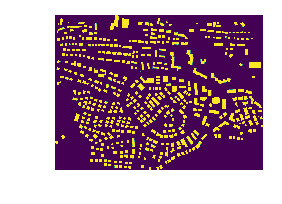

In [9]:
conc2 = np.reshape(model_ex1.predict(np.reshape(image_arr, (1, image_arr.shape[0], image_arr.shape[1], 1))), 
                   (image_arr.shape[0], image_arr.shape[1]))

fig = plt.figure(figsize=(image_arr.shape[1] / 1000, image_arr.shape[0] / 1000), dpi=100, frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(conc2)
#ax.imshow(conc2, aspect='normal')
fig.savefig("OutputTest.png", dpi=1000)

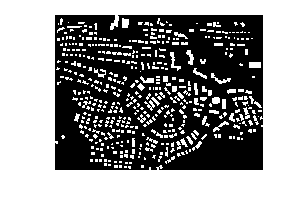

In [10]:
fig = plt.figure(figsize=(image_arr.shape[1] / 1000, image_arr.shape[0] / 1000), dpi=100, frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
conc2 = conc2 > 0.1
plt.imshow(conc2, cmap='gray')
#ax.imshow(conc2, aspect='normal')
fig.savefig("OutputTest_BW", dpi=1000)

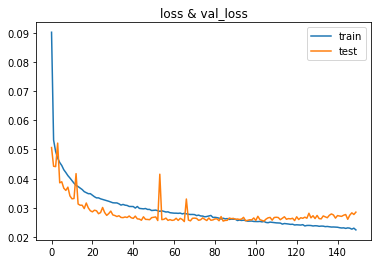

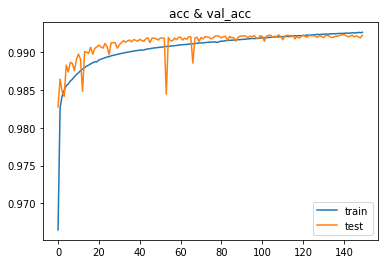

In [17]:
### Plot history of average covariance - accuracy and loss of the models
plt.figure()
plt.plot(History1.history['loss'])
plt.plot(History1.history['val_loss'])
plt.title('loss & val_loss')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig("loss", dpi=1000)

plt.figure()
plt.plot(History1.history['acc'])
plt.plot(History1.history['val_acc'])
plt.title('acc & val_acc')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig("acc", dpi=1000)

(483, 558)
(480, 556)
(418, 750)
(416, 748)


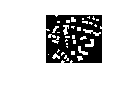

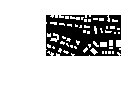

In [16]:
def testIndependet(fn):
    
    image_arr = readImg(fn)
    print(image_arr.shape)
    
    if image_arr.shape[0] % 4 != 0:
        n = image_arr.shape[0] % 4
        new_x = image_arr.shape[0] - n
    else:
        new_x = image_arr.shape[0]


    if image_arr.shape[1] % 4 != 0:
        n = image_arr.shape[1] % 4
        new_y = image_arr.shape[1] - n
    else:
        new_y = image_arr.shape[1]

    image_arr = image_arr[:new_x, :new_y]
    print(image_arr.shape)
    
    conc2 = np.reshape(model_ex1.predict(np.reshape(image_arr, (1, image_arr.shape[0], image_arr.shape[1], 1))), 
                       (image_arr.shape[0], image_arr.shape[1]))
    
    
    
    fig = plt.figure(figsize=(image_arr.shape[1] / 1000, image_arr.shape[0] / 1000), dpi=100, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    #plt.imshow(conc2)
    #fig.savefig(fn[:-4] + '_out.png', dpi=1000)
    
    conc2 = conc2 > 0.1
    plt.imshow(conc2, cmap='gray')
    fig.savefig(fn[:-4] + '_out_bw.png', dpi=1000)
    
    
testIndependet(r"test/FTest1_input_inv.png")
testIndependet(r"test/FTest2_input_inv.png")

In [13]:
model_ex1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flat_conv_a (Conv2D)         (None, None, None, 24)    240       
_________________________________________________________________
flat_conv_b (Conv2D)         (None, None, None, 24)    5208      
_________________________________________________________________
down_conv_1 (Conv2D)         (None, None, None, 24)    5208      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 24)    0         
_________________________________________________________________
flat_conv_1 (Conv2D)         (None, None, None, 64)    13888     
_________________________________________________________________
flat_conv_2 (Conv2D)         (None, None, None, 64)    36928     
_________________________________________________________________
down_conv_2 (Conv2D)         (None, None, None, 64)    36928     
__________